# Install Required Libraries

In [2]:
!pip install transformers datasets


# Import Required Modules

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


In [4]:
from torch.utils.data import Dataset, DataLoader


# Extract the ZIP file

In [5]:
import zipfile
import os

zip_filename = "True.csv.zip"  # Change this to your uploaded file name

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()

# List the extracted files
os.listdir()


['.config', 'True.csv', 'True.csv.zip', 'Fake.csv.zip', 'sample_data']

In [6]:
import zipfile
import os

zip_filename = "Fake.csv.zip"  # Change this to your uploaded file name

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()

# List the extracted files
os.listdir()

['.config',
 'True.csv',
 'True.csv.zip',
 'Fake.csv',
 'Fake.csv.zip',
 'sample_data']

# Load the CSVs from Extracted ZIP

In [7]:
df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

In [8]:
df_fake["label"] = 0  # Fake news
df_real["label"] = 1  # Real news


# Combine & Clean

In [9]:
# Combine title + text
df_fake["content"] = df_fake["title"] + " " + df_fake["text"]
df_real["content"] = df_real["title"] + " " + df_real["text"]

# Final dataset
df = pd.concat([df_fake[["content", "label"]], df_real[["content", "label"]]], ignore_index=True)

# Clean up
df.dropna(subset=["content"], inplace=True)
df = df[df["content"].str.strip() != ""]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,content,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1


# Load BERT Tokenizer & Model

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Prepare Dataset for BERT

In [11]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Split Data

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["content"].values, df["label"].values,
    test_size=0.2,
    random_state=42
)


# Create Dataset and DataLoader

In [13]:
# Tokenizer already loaded
train_dataset = NewsDataset(X_train, y_train, tokenizer)
test_dataset = NewsDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


# Define the BERT + LSTM Model

In [15]:
class BERT_LSTM(nn.Module):
    def __init__(self, hidden_dim=128, n_classes=2):
        super(BERT_LSTM, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_length, 768)
        lstm_out, _ = self.lstm(hidden_states)
        final_hidden_state = lstm_out[:, -1, :]  # last timestep
        out = self.dropout(final_hidden_state)
        return self.fc(out)


# Set Device and Instantiate Model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT_LSTM()
model = model.to(device)


# Define Loss & Optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


# Training Function

In [19]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)


# Evaluation Function

In [20]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)


# Training Loop

In [21]:
EPOCHS = 3  # You can increase for better results

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")

    val_loss, val_acc = eval_model(model, test_loader, loss_fn, device)
    print(f"Val   loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")
    print("-" * 50)


Epoch 1/3
Train loss: 0.2747, accuracy: 0.9007
Val   loss: 0.1512, accuracy: 0.9501
--------------------------------------------------
Epoch 2/3
Train loss: 0.1241, accuracy: 0.9604
Val   loss: 0.1133, accuracy: 0.9667
--------------------------------------------------
Epoch 3/3
Train loss: 0.1367, accuracy: 0.9504
Val   loss: 0.1219, accuracy: 0.9567
--------------------------------------------------


# Save model

In [22]:
# Save model
torch.save(model.state_dict(), "bert_lstm_fakenews.pth")


# prediction

In [23]:
def predict(text, model, tokenizer, max_len=256):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][predicted_class].item()

    return "FAKE" if predicted_class == 0 else "REAL", confidence


In [24]:
text = "Breaking: The government confirms aliens have landed!"
label, confidence = predict(text, model, tokenizer)
print(f"Prediction: {label} (Confidence: {confidence:.2f})")


Prediction: FAKE (Confidence: 0.98)


# Visualize Performance (Confusion Matrix & Report)


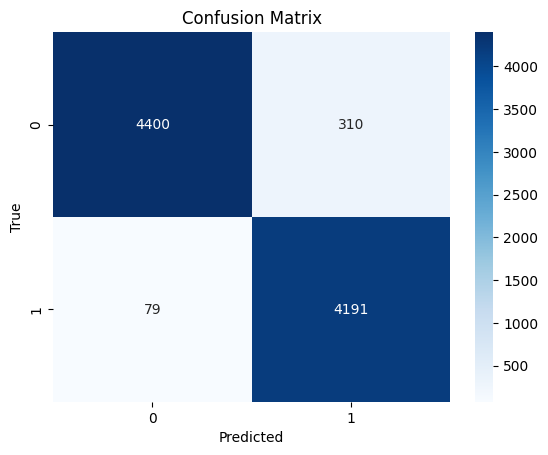

              precision    recall  f1-score   support

        Fake       0.98      0.93      0.96      4710
        Real       0.93      0.98      0.96      4270

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=["Fake", "Real"]))
